# Handwritten Digit Recognition using Deep Learning
In this notebook, we are going to leverage the power of **deep learning** to recognize handwritten digits. We will use the **MNIST dataset**, which is a large dataset of images of handwritten digits that have been collected from various sources and digitized from books and magazines. The techniques we will use:
1. **Data Exploration**: We will explore the structure of the dataset and understand the characteristics of the images.
2. **Fully Connected Neural Network (FNN)**: We will use a simple FNN to recognize handwritten digits.
3.  **Convolutional Neural Networks (CNNs)**: These are a type of neural network that is particularly well-suited for image classification tasks.

## Data Exploration

#### Import Packages

In [105]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap

#### Load MNIST Dataset

In [106]:
train_data = pd.read_csv('Data/train.csv')
train_data.shape

(42000, 785)

In [107]:
test_data = pd.read_csv('Data/test.csv')
test_data.shape

(28000, 784)

In [108]:
train_data.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [109]:
train_data.iloc[:, 0].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6], dtype=int64)

The dataset contains (60000) images of size 28*28 of handwritten digits (0-9). The dataset is split into 2 parts: training set (42000 images) and test set (28000 images). The images are grayscale.

#### Show Sample of the Dataset

Image number 1 is 0


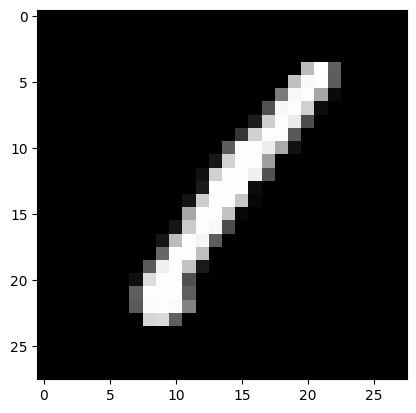

In [110]:
sample = 0  # Change this
print(f"Image number {sample+1} is {train_data.iloc[sample][-1]}")
plt.imshow(np.array(train_data.iloc[sample][1:]).reshape(28, 28), cmap='gray')

#### Show Distribution of the Dataset

Text(0.5, 1.0, 'Histogram of Training Data')

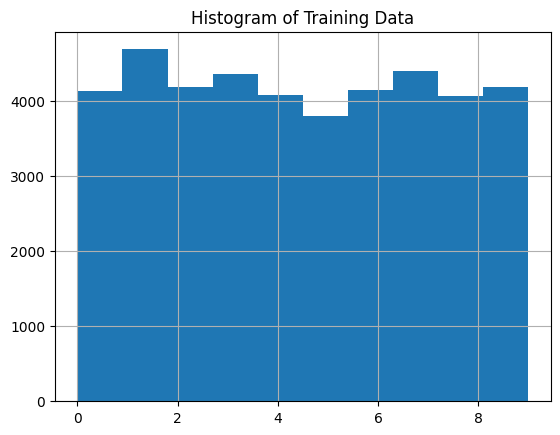

In [111]:
train_data.iloc[:, 0].hist()
plt.title('Histogram of Training Data')

The labels are almost equally distributed

#### Data Visualization

Using Principle Component Analysis (PCA)

The variance explained = [0.0974892  0.07160307]


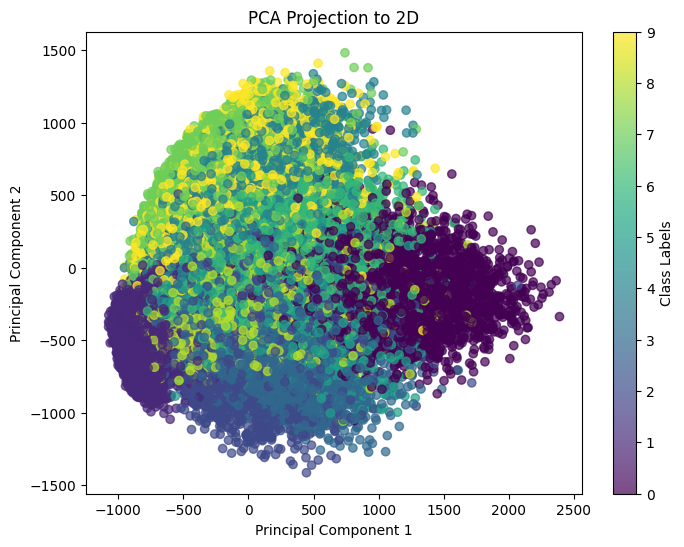

In [112]:
X = train_data.iloc[:, 1:]  # Features
y = train_data.iloc[:, 0]   # Labels
pca = PCA(n_components=2)
data_2d = pca.fit_transform(train_data)
print(f"The variance explained = {pca.explained_variance_ratio_}")
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection to 2D")
plt.show()

Unsurprisingly, a linear dimensionality reduction technique such as PCA is not able to capture the non-linear relationships between the variables. In this case, the first two principal components explain only 16.9% of the variance in the data.

Using UMAP

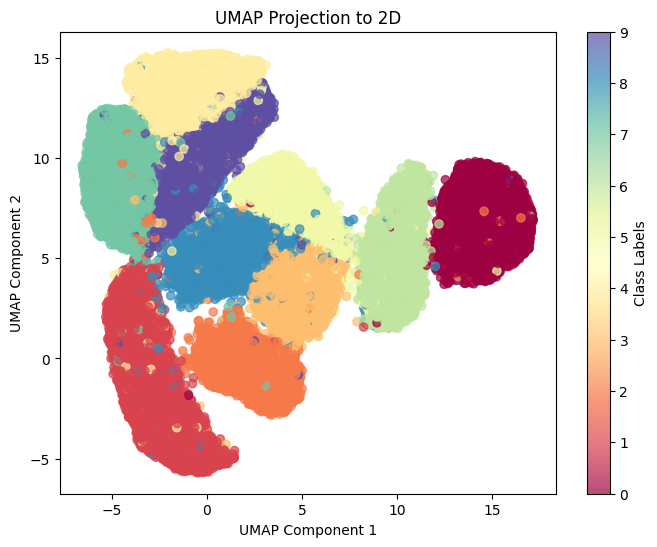

In [113]:
umap_2d = umap.UMAP(n_components=2, random_state=42, n_jobs=-1, min_dist=0.5)
data_2d = umap_2d.fit_transform(X)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=y, cmap='Spectral', alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("UMAP Projection to 2D")
plt.show()

Now, it's obvious that UMAP is a more complex algorithm than PCA, and it's not surprising that it's slower. However, the difference in speed is not as dramatic as one might expect, especially considering that UMAP is a more powerful algorithm and made a great job of preserving the structure of the data.

## Deep Learning Models

#### Import Packages

In [114]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split labels and images
labels = train_data.iloc[:, 0].values  # First column is the label
images = train_data.iloc[:, 1:].values  # Remaining columns are pixel values

# Normalize pixel values to [0,1]
images = images / 255.0

#### Custom Dataset

In [116]:
class MNISTCSV(Dataset):
    def __init__(self, train, images, labels=None, transform=None):
        self.train = train
        self.images = torch.tensor(images, dtype=torch.float32)  # Convert to tensor
        self.labels = torch.tensor(labels, dtype=torch.long) if train else None  # Only store labels if train=True
        self.transform = transform

    def __len__(self):
        return len(self.images)  # Use images length instead of labels

    def __getitem__(self, idx):
        img = self.images[idx].reshape(1, 28, 28)  # Reshape to (1, 28, 28)

        if self.transform:
            img = self.transform(img)

        if self.train:
            return img, self.labels[idx]  # Return image and label for training

        return img  # Only return image for testing

In [117]:
# Create dataset
mnist_dataset = MNISTCSV(True, images, labels)

# Create DataLoader
mnist_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

## Fully Connected Neural Network (FNN)

#### Network Architecture

In [118]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Load Data Using DataLoader

#### Model Training

In [119]:
# Hyperparameters
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 3

In [120]:
# Initialize model, loss, and optimizer
nn_model = NN(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

In [121]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(mnist_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        data = data.reshape(data.shape[0], -1)

        # forward
        scores = nn_model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

100%|██████████| 657/657 [00:02<00:00, 269.08it/s]


Epoch 1, Loss: 0.3824


100%|██████████| 657/657 [00:02<00:00, 289.83it/s]


Epoch 2, Loss: 0.2148


100%|██████████| 657/657 [00:02<00:00, 278.04it/s]

Epoch 3, Loss: 0.1501


## Convolutional Neural Networks (CNNs)

#### Network Architecture

In [122]:
class CNN(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_channels,
            out_channels = 8,
            kernel_size=(3,3),
            stride=1,
            padding=1)
        self.conv2 = nn.Conv2d(
            in_channels = 8,
            out_channels = 16,
            kernel_size=(3,3),
            stride=1,
            padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.fc1 = nn.Linear(16*7*7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(-1, 16*7*7)
        x = self.fc1(x)
        return x
    

#### Model Training

In [123]:
# Hyperparameters
in_channels = 1
num_classes = 10
learning_rate = 3e-4
batch_size = 64
num_epochs = 3

In [124]:
# Initialize network
cnn_model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [125]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(mnist_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = cnn_model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

100%|██████████| 657/657 [00:08<00:00, 79.53it/s]


Epoch 1, Loss: 0.2683


100%|██████████| 657/657 [00:08<00:00, 80.02it/s]


Epoch 2, Loss: 0.4327


100%|██████████| 657/657 [00:08<00:00, 79.96it/s]

Epoch 3, Loss: 0.3125


## Models Testing

In [126]:
# Normalize pixel values
test_images = test_data.values / 255.0

# Create dataset and dataloader
test_dataset = MNISTCSV(False, test_images)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [127]:
nn_model.eval()  # Set model to evaluation mode
nn_predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        batch = batch.to(device)
        batch = batch.reshape(batch.shape[0], -1)
        outputs = nn_model(batch)
        _, predicted = torch.max(outputs, 1)
        nn_predictions.extend(predicted.cpu().numpy())

Testing: 100%|██████████| 438/438 [00:00<00:00, 941.98it/s]


In [128]:
cnn_model.eval()  # Set model to evaluation mode
cnn_predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        batch = batch.to(device)  # Move to GPU if available
        output = cnn_model(batch)
        _, predicted = torch.max(output, 1)
        cnn_predictions.extend(predicted.cpu().numpy())

Testing: 100%|██████████| 438/438 [00:02<00:00, 190.10it/s]


## Save Models & Predictions

In [129]:
# Save predictions to CSV
df_preds = pd.DataFrame({"Predicted": nn_predictions})
df_preds.to_csv("predictions/nn_predictions.csv", index=False)

In [130]:
# Save predictions to CSV
df_preds = pd.DataFrame({"Predicted": cnn_predictions})
df_preds.to_csv("predictions/cnn_predictions.csv", index=False)

In [131]:
torch.save(nn_model, "saved_models/nn_model.pth")

In [132]:
torch.save(cnn_model, "saved_models/cnn_model.pth")